# Metodika vyhodnotenia siete

Skript sprevádzajúci Vyhlášku ktorou sa ustanovuje metodika vyhodnotenia siete, podrobnosti o podmienkach pre tvorbu siete a podrobnosti o postupe pri kategorizácii nemocníc.

## Úvodné nastavenie

Načítanie knižníc a nastavenie parametrov

In [1]:
%load_ext autoreload

In [4]:
%pwd

'/home/olve/mzsr/OSN-public/vyhodnotenie_siete'

In [2]:
import sys
sys.path.append('../')

In [5]:
sys.path

['/home/olve/miniconda3/envs/osn/lib/python311.zip',
 '/home/olve/miniconda3/envs/osn/lib/python3.11',
 '/home/olve/miniconda3/envs/osn/lib/python3.11/lib-dynload',
 '',
 '/home/olve/miniconda3/envs/osn/lib/python3.11/site-packages',
 '/home/olve/mzsr/OSN-public',
 '../']

In [7]:
# Aby fungovalo nacitanie spolocnych funkcii, je nutne ich nainstalovat cez `pip install .` na urovni, kde sa nachadza pyproject.toml

from OSN_common.nacitanie_dat import nacitaj_zoznam_poistencov, nacitaj_zoznam_obci, nacitaj_zoznam_nemocnic, nacitaj_vsetku_starostlivost_s_ms, nacitaj_programovy_profil, nacitaj_zoznam_ms, nacitaj_siet_nemocnic
from OSN_common.pomocne_funkcie import rimska_cislica, zisti_uroven_ms
from vyhodnotenie_siete.podmienky_pre_tvorbu_siete import NEMOCNICE, OBCE, priprav_poistencov, priprav_urovne_siete, priprav_matice, vyhodnot_podmienky_tvorby_siete

import pandas as pd
pd.set_option("mode.copy_on_write", True)
import numpy as np
from collections import defaultdict

%autoreload 2

In [8]:
# Rok, za ktory pochadzaju vychodnocovane data
_rok = 2023

# Verzia vyhlasky (a prisluchajuceho algoritmu na priradenie medicinskych sluzieb)
_verzia = 'v2024.2'

## Hodnotenie podmienok tvorby siete

### Hodnotenie geografickej dostupnosti

§ 4 
__Geografická dostupnosť ústavnej starostlivosti__

1. Obcou s nemocnicou na danej úrovni sa rozumie obec, v ktorej má sídlo aspoň 1 nemocnica danej úrovne alebo vyššej úrovne. 
2. Spodným limitom geografickej dostupnosti na danej úrovni sa rozumie počet minút definovaný v §8 zákona odseku 2 až odseku 5 v bode a), pre ktorý má platiť, že najmenej 90 % poistencov má čas dojazdu do obce s nemocnicou na danej úrovni do tohto počtu minút.  
3. Horným limitom geografickej dostupnosti na danej úrovni sa rozumie počet minút definovaný v §8 zákona odseku 2 až odseku 5 v bode a), pre ktorý má platiť, že najviac 1,5 % poistencov má čas dojazdu do obce s nemocnicou na danej úrovni nad tento počet minút. 
4. Výpočet geografickej dostupnosti ústavnej starostlivosti v kandidátskej sieti prebieha pre každú úroveň siete nasledovne:  
 - pre každú obec sa v kandidátskej sieti nemocníc nájde obec s nemocnicou na danej úrovni, pre ktorú je dojazd z danej obce do obce s nemocnicou najnižší. Tento čas dojazdu sa ďalej považuje za čas dojazdu do spádovej nemocnice na danej úrovni. 
 - spočíta sa počet poistencov s pobytom v obciach s časom dojazdu do spádovej nemocnice nižším než dolný limit geografickej dostupnosti na danej úrovni a podelí sa počtom všetkých poistencov. Pokiaľ je tento pomer vyšší alebo rovný ako 90 %, kandidátska sieť spĺňa podmienku spodného limitu geografickej dostupnosti pre danú úroveň. 
 - spočíta sa počet poistencov s pobytom v obciach s časom dojazdu do spádovej nemocnice vyšším než horný limit geografickej dostupnosti na danej úrovni a podelí sa počtom všetkých poistencov. Pokiaľ je tento pomer nižší alebo rovný ako 1,5 %, kandidátska sieť spĺňa podmienku horného limitu geografickej dostupnosti pre danú úroveň. 
5. Hodnotenie plnenia geografickej dostupnosti ústavnej starostlivosti kandidátskej siete je vyjadrené v Prílohe č. 1. 

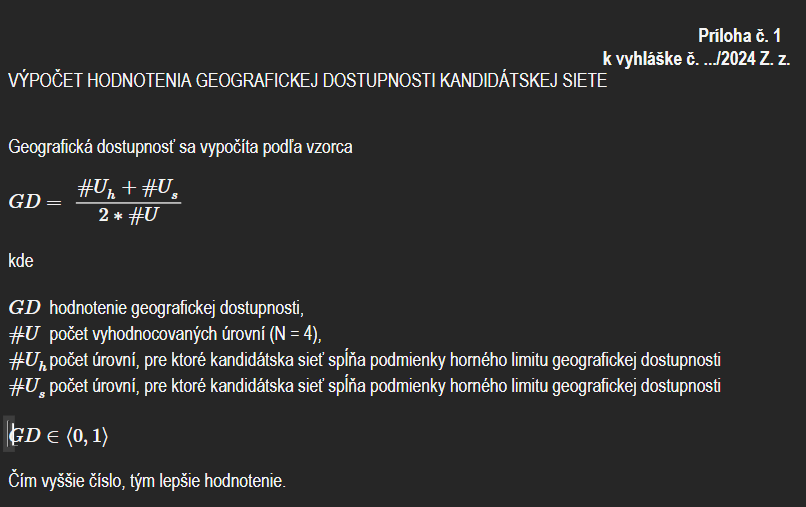

In [ ]:
from podmienky_pre_tvorbu_siete import vyhodnot_geograficku_dostupnost


### Hodnotenie počtu poistencov v spádovom území

§ 5 
__Počet poistencov v spádovom území__

1. Spodným limitom počtu poistencov na danej úrovni sa rozumie počet definovaný v §8 zákona odseku 2 až odseku 5 písmena b) pre ktorý má platiť, že každá nemocnica danej úrovne alebo vyššej úrovne má počet poistencov v spádovom území najmenej tento počet. 
2. Horným limitom počtu poistencov na danej úrovni sa rozumie počet definovaný v §8 zákona odseku 2 až odseku 5 písmena b), pre ktorý má platiť, že každá nemocnica danej úrovne alebo vyššej úrovne má počet poistencov v spádovom území najmenej tento počet. 
3. Výpočet počtu poistencov v spádovom území v kandidátskej sieti prebieha pre každú úroveň siete nasledovne: 
 - pre každú obec sa v kandidátskej sieti nemocníc nájde obec s nemocnicou na danej úrovni, pre ktorú je dojazd z danej obce do obce s nemocnicou najnižší. Táto obec s nemocnicou je ďalej pre danú obec spádová na danej úrovni. 
 - pre každú obec s nemocnicou na danej úrovni sa určí spádové územie ako zoznam obcí, pre ktoré je daná obec s nemocnicou spádová na danej úrovni. 
 - pre každú nemocnicu na danej úrovni alebo vyššej úrovni sa spočíta počet poistencov v spádovom území na danej úrovni ako počet poistencov v spádovom území obce s nemocnicou na danej úrovni, v ktorej má daná nemocnica sídlo, podelený počtom nemocníc so sídlom v danej obci s nemocnicou na danej úrovni.  
4. Pre každú úroveň kandidátskej siete platí nasledovné: Každá nemocnica spĺňa podmienku počtu poistencov na danej úrovni, pokiaľ počet poistencov v jej spádovom území na danej úrovni je vyšší alebo rovný ako spodný limit a zároveň nižší alebo rovný ako horný limit definovaný v zákone pre danú úroveň. 
5. Časom dojazdu pre okres sa rozumie priemerný čas dojazdu do nemocnice z obcí v danom okrese vypočítanom ako vážený priemer času dojazdu, pričom váha pre danú obec je pomer počtu poistencov s pobytom v danej obci v pomere k celkovému počtu poistencov s pobytom v danom okrese. 
6. Pre II. úroveň kandidátskej siete zároveň platí aj nasledovné: 
 - každá nemocnica III. úrovne alebo vyššej úrovne spĺňa podmienku počtu poistencov na II. úrovni aj pokiaľ je počet poistencov v jej spádovom území na II. úrovni vyšší, ako horný limit definovaný v zákone pre II. úroveň. 
 - každá nemocnica, ktorej počet poistencov v jej spádovom území na II. úrovni je menej ako 100 000 poistencov ale najmenej 75 000 poistencov, spĺňa podmienku počtu poistencov na II. úrovni, pokiaľ existuje alternatívna kandidátska sieť nemocníc neobsahujúca danú nemocnicu a zároveň, v ktorej existuje okres, pre ktorý by čas dojazdu presiahol 35 minút, pričom vo vyhodnocovanej kandidátskej sieti je čas dojazdu v tomto okrese pod 35 minút. 
 - každá nemocnica, ktorej počet poistencov v jej spádovom území na II. úrovni je menej ako 75 000 poistencov, spĺňa podmienku počtu poistencov na II. úrovni, pokiaľ existuje alternatívna kandidátska sieť nemocníc neobsahujúca danú nemocnicu a zároveň, v ktorej existuje okres, pre ktorý by čas dojazdu presiahol 45 minút, pričom vo vyhodnocovanej kandidátskej sieti je čas dojazdu v tomto okrese pod 45 minút. 
7. Hodnotenie plnenia počtu poistencov v spádovom území kandidátskej siete je vyjadrené v Prílohe č. 2. 

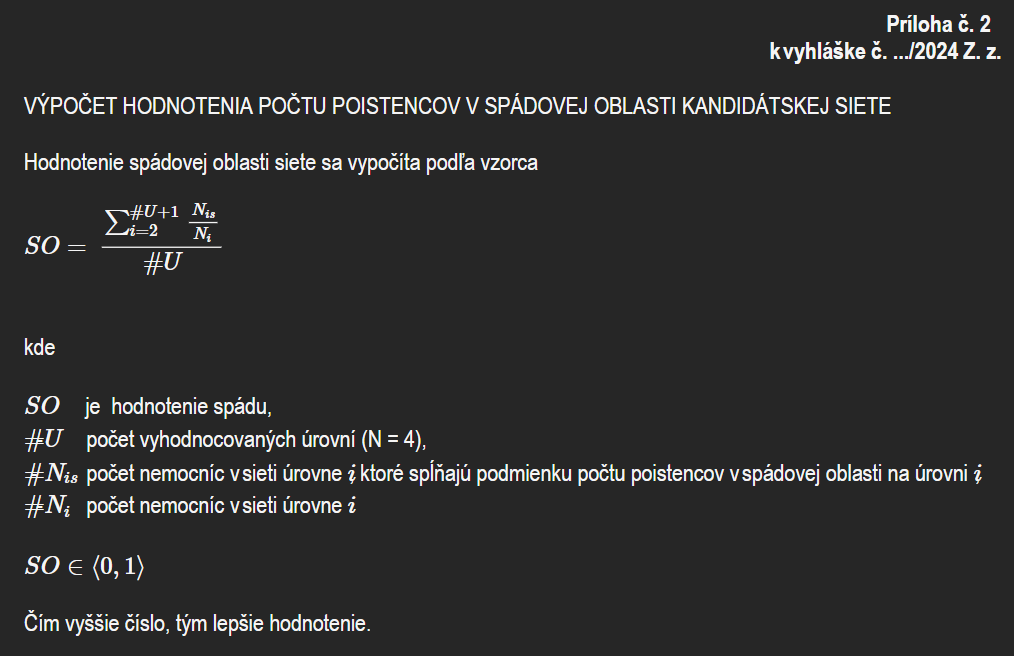

In [ ]:
from podmienky_pre_tvorbu_siete import vyhodnot_spady

### Vyhodnotenie podmienky počtu lôžok

Limity definované prílohou č.6 k nariadeniu vlády č. 640/2008 Z. z.

§ 6 
__Počet lôžok__

1. Počet lôžok v jednotlivých nemocniciach získava ministerstvo z nasledovných zdrojov: 
 - Žiadosti nemocníc o podmienené zaradenie nemocnice do siete a žiadosti nemocníc o podmienené zvýšenie úrovne nemocnice; 
 - Žiadosti nemocníc o zmenu údajov o mieste prevádzkovania, o počte lôžok a o rozdelení povinných programov medzi hlavnou nemocnicou a partnerskou nemocnicou; 
 - Žiadosť o zníženie úrovne nemocnice zaradenej do siete, žiadosť o zrušenie doplnkového programu v nemocnici zaradenej do siete a žiadosť o vyradenie nemocnice zo siete 
 - Údaje poskytnuté Národným centrom zdravotníckych informácií (ďalej len “NCZI”) na základe osobitného kontraktu. 
2. V prípade, že sa jednotlivé zdroje líšia, použije sa údaj z poslednej podanej žiadosti. Pokiaľ žiadna žiadosť neobsahuje údaj o počte lôžok, použije sa údaj z NCZI. 
3. Kandidátska sieť spĺňa podmienku minimálneho počtu lôžok na Slovenskú republiku, pokiaľ je celkový počet lôžok v sieti rovný alebo väčší ako minimálny počet lôžok na Slovenskú republiku ustanovený osobitným predpisom. 
4. Pre každý kraj kandidátska sieť spĺňa podmienku minimálneho počtu lôžok na daný kraj, pokiaľ je celkový počet lôžok v nemocniciach so sídlom v danom kraji rovný alebo väčší ako minimálny počet lôžok na daný kraj ustanovený osobitným predpisom. 
5. Celkové hodnotenie zabezpečenia minimálneho počtu lôžok v kandidátskej sieti je vyjadrené v Prílohe č. 3. 
6. Plnenie minimálneho počtu lôžok sa vyhodnocuje osobitne pre každú nemocnicu, ktorej ministerstvo pri kategorizácii určilo minimálny počet lôžok, ktoré sa musia v nemocnici zabezpečiť.  
7. Hodnotenie plnenia minimálneho počtu lôžok osobitne pre každú nemocnicu nie je súčasťou celkového hodnotenia plnenia podmienok pre tvorbu siete.  

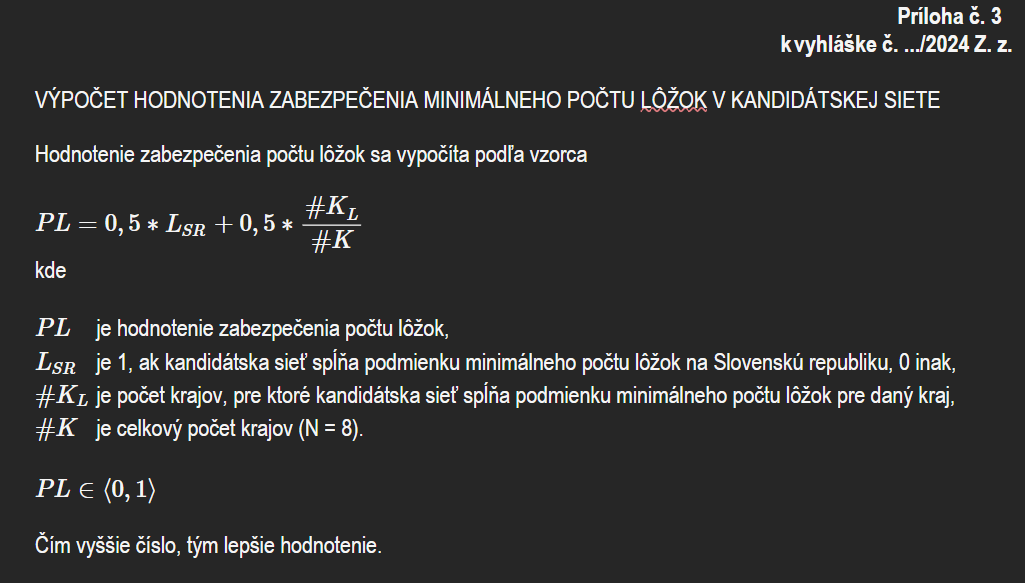

## Celkové vyhodnotenie podmienok tvorby siete

§ 7 
__Celkové hodnotenie plnenia podmienok pre tvorbu siete v kandidátskej sieti__

1. Celkové hodnotenie plnenia podmienok pre tvorbu siete v kandidátskej sieti je vyjadrené v Prílohe č. 4. 

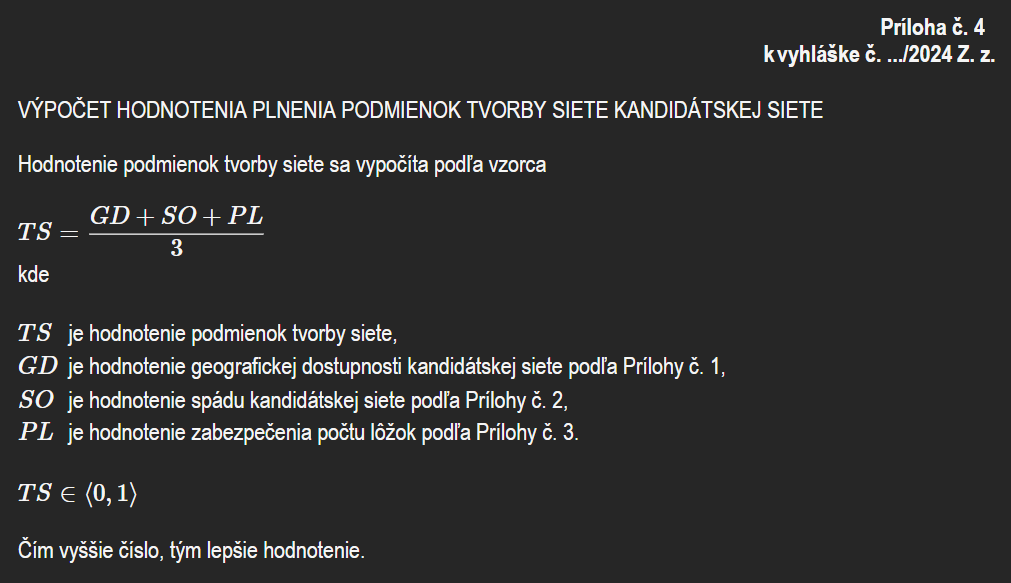

# Podmienky kategorizácie ústavnej starostlivosti 

1. Podmienkami kategorizácie ústavnej starostlivosti sú  
    - poskytovanie všetkých povinných programov a schválených doplnkových programov v rozsahu programového profilu; 
    - poskytovanie všetkých povinných medicínskych služieb v rozsahu povinných programov a schválených doplnkových programov; 
    - plnenie podmienok indikátorov kvality pre ústavnú starostlivosť a ich cieľových hodnôt; 
    - plnenie podmienok každého povinného programu a schváleného doplnkového programu; 
    - plnenie podmienok všetkých povinných medicínskych služieb v rozsahu povinných programov a schválených doplnkových programov.  
2. Podmienkami programu sa rozumie plnenie podmienok v rozsahu 
    - špeciálneho personálneho zabezpečenia;  
    - špeciálneho materiálno-technického vybavenia; 
    - iných programov alebo medicínskych služieb, ktoré sa musia v nemocnici poskytovať súčasne. 
3. Podmienkami medicínskych služieb sa rozumie:  
    - minimálny počet medicínskych služieb, ktoré sa musia v nemocnici alebo u poskytovateľa jednodňovej zdravotnej starostlivosti vykonať alebo ktoré musí lekár vykonať v kalendárnom roku; 
    - indikačné kritériá pre poskytovanie ústavnej starostlivosti v nemocnici (ďalej len „hospitalizácia“); 
    - podmienky pre poskytnutie diagnostiky a liečby počas hospitalizácie; 
    - podmienky pre prepustenie poistenca z hospitalizácie; 
    - podmienky pre prepravu poistenca medzi nemocnicami; 
    - indikátory kvality pre ústavnú starostlivosť a ich cieľové hodnoty; 
    - špeciálne personálne zabezpečenie; 
    - špeciálne materiálno-technické vybavenie; 
    - iné programy alebo medicínske služby, ktoré sa musia v nemocnici poskytovať súčasne.  

## Poskytovanie programu a poskytovanie medicínskej služby 

1. Vyhodnotenie poskytovania medicínskej služby v danom roku je nasledovné: 
    1. zo všetkých nemocníc, ktoré poskytli danú medicínsku službu sa vypočíta priemer počtu poskytnutí medicínskej služby na nemocnicu; 
    2. pokiaľ je tento priemer menší ako 10, daná medicínska služba sa nevyhodnocuje; 
    3. nemocnice, ktoré poskytli danú medicínsku službu v danom roku aspoň v počte 10 % z vypočítaného priemeru splnili podmienku poskytovania danej medicínskej služby v danom roku. 
2. Hodnotenie plnenia podmienok poskytovania všetkých povinných medicínskych služieb v rozsahu povinných programov a schválených doplnkových programov v nemocnici je vyjadrené v Prílohe č. 5. 
3. Nemocnica splnila podmienku poskytovania daného programu v danom období, pokiaľ splnila podmienku poskytovania medicínskej služby pre všetky povinné medicínske služby, ktoré prislúchajú danému programu, a zároveň v ňom nie sú zdieľané a boli v danom roku vyhodnocované podľa odseku 1. 
4. Hodnotenie plnenia podmienky poskytovania všetkých povinných programov a schválených doplnkových programov v rozsahu programového profilu v nemocnici je vyjadrené v Prílohe č.6. 

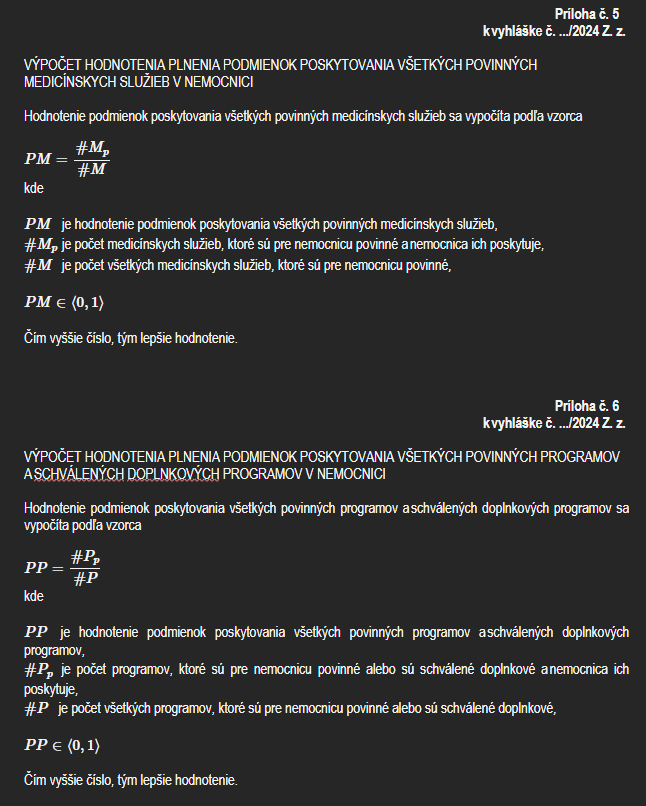

In [ ]:
hospitalizacne_pripady = nacitaj_vsetku_starostlivost_s_ms(_rok, _verzia)

In [ ]:
zoznam_ms = nacitaj_zoznam_ms(_verzia)

In [ ]:
pzs_6 = 'N22399'

In [ ]:
hospitalizacne_pripady['zoznam_ms'] = hospitalizacne_pripady['ms'].str.split('~')

In [ ]:
ms_na_pzs = hospitalizacne_pripady[['id_hp','pzs_6', 'zoznam_ms']].explode('zoznam_ms').pivot_table(index='pzs_6', columns='zoznam_ms', values='id_hp', aggfunc='count')

In [ ]:
priemer_poskytnutia_ms = ms_na_pzs.sum() / ms_na_pzs.notna().sum()

In [ ]:
vyhodnocovane_ms = priemer_poskytnutia_ms[priemer_poskytnutia_ms >= 10].index

In [ ]:
priemer_poskytnutia_ms.filter(vyhodnocovane_ms)

In [ ]:
ms_na_pzs.filter(vyhodnocovane_ms)

In [ ]:
podiel_poskytnutia_ms = ms_na_pzs.filter(vyhodnocovane_ms) / priemer_poskytnutia_ms.filter(vyhodnocovane_ms)

In [ ]:
poskutuju_ms = podiel_poskytnutia_ms >= 0.1

In [ ]:
poskutuju_ms.loc[pzs_6]

## Špeciálne personálne zabezpečenie a špeciálne materiálno-technické vybavenie 

1. Špeciálne personálne zabezpečenie a špeciálne materiálno-technické vybavenie sú ustanovené osobitným predpisom podľa § 44 odseku 2 zákona pre jednotlivé programy a jeho úrovne a pre jednotlivé medicínske služby. 
2. Údaje o napĺňaní požiadaviek špeciálneho personálneho zabezpečenia a špeciálneho materiálno-technického vybavenia ministerstvo získava z 
    - Údaje poskytnuté Národným centrom zdravotníckych informácií (ďalej len “NCZI”) na základe osobitného kontraktu; 
    - žiadosti o podmienené zaradenie nemocnice do siete; 
    - žiadosti o podmienené zvýšenie úrovne nemocnice zaradenej do siete a 
    - žiadosti o podmienené poskytovanie doplnkového programu priloží. 
3. V prípade, že sa jednotlivé zdroje líšia, použije sa údaj z poslednej podanej žiadosti. Pokiaľ žiadna žiadosť neobsahuje daný údaj, použije sa údaj z NCZI.  
4. Zabezpečením špecifického personálu sa rozumie existencia úväzkov s danou špecifikáciou v danej výške v nemocnici. 
5. Výhradným zabezpečením špecifického personálu sa rozumie existencia úväzku s danou špecifikáciou v danej výške v nemocnici, ktorý nie je súčasťou žiadnej inej podmienky výhradného zabezpečenia špecifického personálu.  
6. Pokiaľ osobitný predpis vyžaduje špecifický personál, rozumie sa tým výhradné zabezpečenie daného personálu v hodnote súčtu aspoň 1,0. 
7. Pokiaľ osobitný predpis vyžaduje nepretržitú prítomnosť špecifického personálu, rozumie sa tým výhradné zabezpečenie daného personálu v hodnote súčtu aspoň 3,0. 
8. Pokiaľ osobitný predpis vyžaduje nepretržitú dostupnosť špecifického personálu, rozumie sa tým zabezpečenie daného personálu v hodnote súčtu aspoň 3,0 a zároveň výhradné zabezpečenie daného personálu v hodnote súčtu aspoň 0,3. 
9. Pokiaľ osobitný predpis vyžaduje dostupnosť konziliárnej služby špecifického personálu, rozumie sa tým výhradné zabezpečenie daného personálu v hodnote súčtu aspoň 0,1.  
10. Hodnotenie plnenia špecifického personálneho zabezpečenia pre jednotlivé medicínske služby nevstupuje do hodnotenia plnenia špeciálneho personálneho zabezpečenia v nemocnici. 
11. Vyhodnotenie plnenia podmienok špecifického personálneho zabezpečenia v nemocnici je vyjadrené v Prílohe č. 8. 
12. Hodnotenie plnenia špeciálneho materiálno-technického vybavenia pre jednotlivé medicínske služby nevstupuje do hodnotenia plnenia špeciálneho materiálno-technického vybavenia v nemocnici. 
13. Vyhodnotenie plnenia podmienok špecifického materiálno-technického vybavenia v nemocnici je vyjadrené v Prílohe č. 9. 

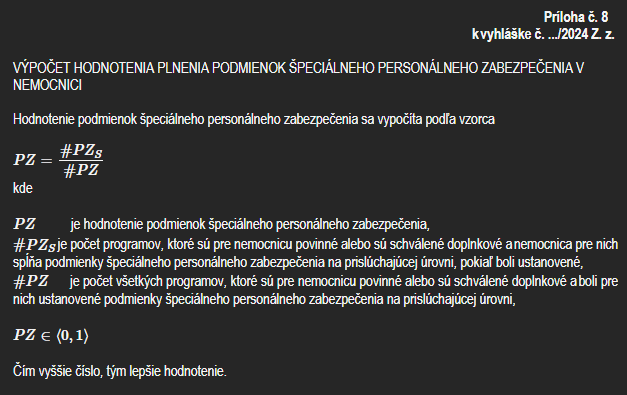

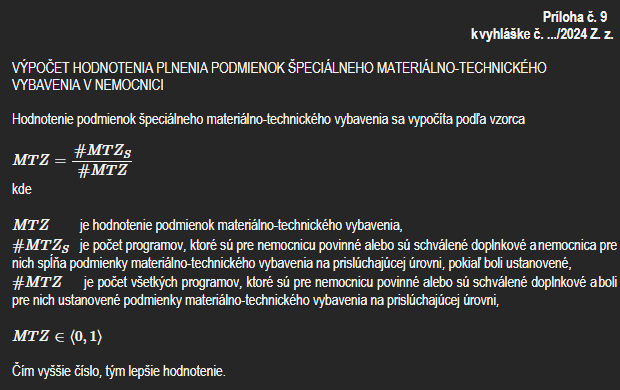

In [ ]:
# podmienky_personal = pd.read_excel(f'personalne_zabezpecenie_{_verzia}.xlsx', sheet_name='Personálne požiadavky', dtype=defaultdict(lambda: 'str', {'ČP': "Int8", 'Úroveň programu': 'Int8'}))
# podmienky_personal['Úväzok'] = podmienky_personal['Úväzok'].str.replace('?', '').astype(float)

In [ ]:
podmienky_personal = pd.read_excel('personalne_zabezpecenie/priloha_3_personal.xlsx', index_col=[0,1,2])
podmienky_personal.columns

In [ ]:
personal = pd.read_excel('personalne_zabezpecenie/Sumar_dotazniky_1_kolo_2022.xlsx', sheet_name='personal')
personal.columns = ['pzs_6', 'pzs_8', 'pzs_12', 'kod_pracovnika', 'kod_odbornosti', 'nazov_odbornosti', 'uvazok_TPP', 'uvazok_dohoda', 'uvazok_dodavatel', 'poznamka']
personal.loc[:,personal.filter(like='uvazok').columns] = personal.filter(like='uvazok').replace(',', '.', regex=True).replace(' ', '0', regex=True).replace('MD', '0', regex=True).astype('float')
personal['celkovy_uvazok'] = personal[['uvazok_TPP', 'uvazok_dohoda', 'uvazok_dodavatel']].fillna(0).sum(axis=1)
personal.columns

In [ ]:
a=defaultdict(lambda: 0, personal[(personal['pzs_6'] == pzs_6)].groupby('kod_odbornosti')['celkovy_uvazok'].sum().to_dict())

In [ ]:
kandidatska_siet = pd.read_excel(
        "kandidatska_siet.xlsx",
        index_col=[0, 1, 2, 3],
        header=[0, 1, 2],
    )

nemocnice = nacitaj_zoznam_nemocnic()
vseobecne_nemocnice = nemocnice[nemocnice['typ_nemocnice']=='Všeobecná nemocnica']['pzs_6']

rozdiely = pd.DataFrame(columns=['pzs_6', 'cislo_programu', 'nazov_programu', 'uroven_programu', 'nazov_odbornosti', 'kod_odbornosti', 'vyhradny_uvazok', 'dostupny', 'rozdiel'])

for pzs_6 in kandidatska_siet.index.get_level_values('pzs_6'):
    if pzs_6 not in vseobecne_nemocnice.values:
        continue   
    
    nemocnica = kandidatska_siet.loc[pzs_6]
    
    print(f'Vyhodnocovanie pre nemocnicu {nemocnica.index[0]}.')
    
    vyhodnocovane_programy = []
    for gi in range(0,nemocnica.shape[1],5):
        skupina = nemocnica.iloc[:,gi:gi+5].replace('N', pd.NA).replace('D', pd.NA).squeeze()
        stlpec = skupina.last_valid_index()
        if stlpec:
            vyhodnocovane_programy.append((stlpec, skupina[stlpec]))

    dostupni_lekari = defaultdict(lambda: 0, personal[(personal['pzs_6'] == pzs_6)].groupby('kod_odbornosti')['celkovy_uvazok'].sum().to_dict())
    
    celkove_vyhradne_poziadavky = defaultdict(lambda: 0)
    celkove_poziadavky_dostupnosti = defaultdict(lambda: 0)
    for program, _ in vyhodnocovane_programy:
        cislo_programu, nazov_programu, uroven_programu = program
        poziadavky = podmienky_personal.loc[cislo_programu, uroven_programu]
        if not poziadavky.empty:
            # print(f'Vyhodnocovanie pre {cislo_programu}: {nazov_programu} na úrovni {uroven_programu}.')
            for skupina in poziadavky.index.unique():
                for _, poziadavka in poziadavky.loc[[skupina]].iterrows():
                    kod_odbornosti = poziadavka['kod_odbornosti']
                    nazov_odbornosti = poziadavka['nazov_odbornosti']
                    celkove_vyhradne_poziadavky[kod_odbornosti] += poziadavka['vyhradny_uvazok']
                    celkove_poziadavky_dostupnosti[kod_odbornosti] += poziadavka['dostupny_uvazok']
    
    chybajuci_personal = pd.DataFrame(columns=['pzs_6', 'kod_odbornosti', 'rozdiel'])
    for p in celkove_vyhradne_poziadavky:
        dostupni_lekari[p] -= celkove_vyhradne_poziadavky[p]
        if dostupni_lekari[p] < 0:
            print(f'Nedostatočná výhradná dostupnosť lekárov kódu {p} ({dostupni_lekari[p]}).')
            chybajuci_personal = pd.concat([chybajuci_personal, pd.DataFrame([[pzs_6, p, dostupni_lekari[p]]], columns=chybajuci_personal.columns)])
        
    for p in celkove_poziadavky_dostupnosti:
        if dostupni_lekari[p] < celkove_poziadavky_dostupnosti[p]:
            print(f'Nedostatočná dostupnosť lekárov kódu {p} ({dostupni_lekari[p] - celkove_poziadavky_dostupnosti[p]}).')
    

chybajuci_personal

In [ ]:
rozdiely['chybajuci'] = rozdiely['rozdiel'].clip(upper=0)

In [ ]:
programovy_profil = nacitaj_programovy_profil(2024, _verzia)

In [ ]:
rozdiely[(rozdiely['cislo_programu'] == 24) & (rozdiely['uroven_programu'] == 3)]

In [ ]:
chybajuce_programy = rozdiely[rozdiely['pzs_6'].isin(vseobecne_nemocnice)].groupby(['cislo_programu', 'uroven_programu', 'kod_odbornosti'], dropna=False)['chybajuci'].sum().sort_values().reset_index()

In [ ]:
chybajuce_programy

In [ ]:
chybajuci_personal = rozdiely.groupby('pzs_6')['chybajuci'].sum().sort_values()

In [ ]:
chybajuci_personal = chybajuci_personal.to_frame().merge(nemocnice, left_index=True, right_on='pzs_6')

# Potreba ústavnej zdravotnej starostlivosti

§ 2 zákona

5. Potreba ústavnej starostlivosti je celkový objem medicínskych služieb, ktorými sa zabezpečí predpokladaná ústavná starostlivosť pre poistencov príslušného územia. Potreba ústavnej starostlivosti je určená počtom poskytnutých medicínskych služieb v nemocniciach uvedených v zozname kategorizovaných nemocníc podľa § 11 a u poskytovateľa jednodňovej zdravotnej starostlivosti, v predchádzajúcom roku pre každý program v programovom profile navýšeným o počet poistencov zaradených v zozname čakajúcich poistencov (§ 40), so zohľadnením prípadnej krízovej situácie v predchádzajúcom kalendárnom roku, ako aj predpokladanej budúcej potreby ústavnej starostlivosti ovplyvnenej vývojom v demografii, chorobnosti a liečebných postupoch. Krízová situácia na účely toho zákona je výnimočný stav, núdzový stav alebo mimoriadna situácia vyhlásené vládou Slovenskej republiky.

§ 17 metodiky

Potrebou ústavnej starostlivosti v kandidátskej sieti na danej úrovni v danom období pre dané územie sa rozumie celkový objem medicínskych služieb na danej úrovni, ktoré poskytli všetky nemocnice v kandidátskej sieti v danom období poistencom s pobytom na danom území navýšený o počet poistencov s pobytom na danom území zaradených v zozname čakajúcich poistencov pre všetky medicínske služby na danej úrovni za dané obdobie. 


Uvažujú sa všetky hospitalizačné prípady za minulý rok vykázané nemocnicami v zozname nemocníc. Ako úroveň je uvažovaná úroveň medicínskej služby, ktorá bola priradená ako prvá hospitalizačnému prípadu podľa algoritmu prislúchajúcemu danej verzii vyhlášky.

Alternatívne je možné uvažovať ako úroveň najvyššiu úroveň medicínskej zlužby zo všetkých medicínskych služieb priradených k danému hospitalizačnému prípadu.



In [ ]:
hospitalizacne_pripady = nacitaj_vsetku_starostlivost_s_ms(_rok, _verzia)

In [ ]:
potreba = hospitalizacne_pripady[hospitalizacne_pripady['pzs_6'].isin(nemocnice['pzs_6'])]
potreba = potreba.merge(nemocnice[['pzs_6', 'uroven_nemocnice']], how='left')
potreba['uroven'] = potreba['uroven_ms'].str.split('~').str[0]


K starostlivosti z minulého roka je nutné pripočítať poistencov čakajúcich na čakacích listinách. Využijeme na to dáta z tabuľky č. 10 DR 211. K potrebe pripočítame všetky návrhy, ktré boli podané v sledovanom roku a majú plánovaný dátum poskytnutia v roku nasledujúcom a ďalších, pričom odpočítame všetky vyradené návrhy.

In [ ]:
potreba.groupby('uroven')['id_hp'].count()

In [ ]:
potreba.groupby('uroven_nemocnice')['id_hp'].count()

## Vyhodnotenie programov

In [ ]:
# Pre vyhodnotenie programov využijeme programový profil platný vo vyhodnocovanom roku. Za rok 2023 vzhľadom na veľké zmeny vo vyhláške využijeme programový profil na rok 2024 s platnosťou od 1.8.2024. 

programovy_profil = nacitaj_programovy_profil(2024, _verzia)
zoznam_ms = nacitaj_zoznam_ms(_verzia)

In [ ]:
povinne_programy = {}
doplnkove_programy = {}
nepovinne_programy = {}
for uroven in range(2,6):
    povinne_programy[uroven] = programovy_profil[(programovy_profil[f'povinnost_programu_{rimska_cislica(uroven)}'] == 'P')].groupby(['cislo_programu', 'nazov_programu'])['uroven_programu'].apply(list)
    doplnkove_programy[uroven] = programovy_profil[(programovy_profil[f'povinnost_programu_{rimska_cislica(uroven)}'] == 'D')].groupby(['cislo_programu', 'nazov_programu'])['uroven_programu'].apply(list)
    nepovinne_programy[uroven] = programovy_profil[(programovy_profil[f'povinnost_programu_{rimska_cislica(uroven)}'] == 'N')].groupby(['cislo_programu', 'nazov_programu'])['uroven_programu'].apply(list)


### Vyhodnotenie minimálneho počtu medicínskych služieb

In [ ]:
# Zaujímajú nás MS, ktoré sú primárne pre daný program (nie sú v danom programe zdieľané) a majú definované minimum na nemocnicu
ms_s_minimalnym_poctom = zoznam_ms[(zoznam_ms['zdielana_ms'] == False) & zoznam_ms['minimum_na_nemocnicu'].notna()]

In [ ]:
pzs_6 = 'N22399' # Brezno
uroven = 2

# pre danú nemocnicu nás zaujímajú iba tie MS, ktoré patria do povinného programu pre danú úroveň nemocnice a zároveň sú povinnou MS na danej úrovni nemocnice
vyhodnocovane_ms = ms_s_minimalnym_poctom[ms_s_minimalnym_poctom['cislo_programu'].isin(povinne_programy[uroven].droplevel(1).index) & (ms_s_minimalnym_poctom[f'povinnost_ms_{rimska_cislica(uroven)}'] == 'P')][['kod_ms', 'nazov_ms', 'minimum_na_nemocnicu']]

jednoduche_limity = vyhodnocovane_ms[~vyhodnocovane_ms['minimum_na_nemocnicu'].str.contains('\*')]
jednoduche_limity['limit'] = jednoduche_limity['minimum_na_nemocnicu'].astype(int)
suctove_limity = vyhodnocovane_ms[vyhodnocovane_ms['minimum_na_nemocnicu'].str.contains('\*')]
suctove_limity['kategoria'] = suctove_limity['minimum_na_nemocnicu'].str.split('*').str[1]
suctove_limity['limit'] = suctove_limity['minimum_na_nemocnicu'].str.split('*').str[0].astype(int)
celkovy_pocet_limitov = len(jednoduche_limity) + len(suctove_limity['kategoria'].unique())

In [ ]:
vyhodnocovane_pripady = hospitalizacne_pripady[hospitalizacne_pripady['pzs_6'] == pzs_6]
vyhodnocovane_pripady['zoznam_ms'] = vyhodnocovane_pripady['ms'].str.split('~')

pocty_ms = vyhodnocovane_pripady.explode('zoznam_ms').groupby('zoznam_ms')['id_hp'].count()
# vyhodnocovane_pripady['hlavna_ms'] = vyhodnocovane_pripady['zoznam_ms'].str[0]
# pocty_ms = vyhodnocovane_pripady.groupby('hlavna_ms')['id_hp'].count()

plnenie_jednoduchych_limitov = jednoduche_limity.merge(pocty_ms, right_index=True, left_on='kod_ms')
splnane_limity = sum(plnenie_jednoduchych_limitov['id_hp'] >= plnenie_jednoduchych_limitov['limit'])

plnenie_suctovych_limitov = suctove_limity.merge(pocty_ms, right_index=True, left_on='kod_ms').groupby('kategoria').agg({'limit': 'max', 'id_hp': 'sum'})
splnane_limity += sum(plnenie_suctovych_limitov['id_hp'] >= plnenie_suctovych_limitov['limit'])

splnane_limity / celkovy_pocet_limitov

In [ ]:
plnenie_jednoduchych_limitov['cislo_programu'] = plnenie_jednoduchych_limitov['kod_ms'].str.split('-').str[0].str[1:].astype(int)
plnenie_jednoduchych_limitov['splna'] = plnenie_jednoduchych_limitov['id_hp'] >= plnenie_jednoduchych_limitov['limit']
plnenie_jednoduchych_limitov = plnenie_jednoduchych_limitov.merge(programovy_profil[['cislo_programu', 'nazov_programu']].drop_duplicates(), on='cislo_programu')
plnenie_jednoduchych_limitov.groupby(['cislo_programu', 'nazov_programu']).agg({'splna': ['count', 'sum']})

In [ ]:
plnenie_suctovych_limitov

# § 9 Vyhodnotenie siete

Vyhodnotením siete sa rozumie vyhodnotenie splnenia podmienok pre tvorbu siete, vyhodnotenie splnenia podmienok kategorizácie ústavnej starostlivosti nemocnicami zaradenými do siete a zistenie potreby ústavnej starostlivosti. Vyhodnotenie siete vykoná ministerstvo zdravotníctva každoročne do 31. júla z údajov podľa § 3 ods. 1 písm. d), § 37 a 39 za predchádzajúci kalendárny rok.

- pre každú úroveň
1. vyhodnotenie geografickej dostupnosti ústavnej starostlivosti,
2. vyhodnotenie veľkosti spádového územia pre každú nemocnicu zaradenú do siete,
3. vyhodnotenie zabezpečenia minimálneho počtu lôžok v sieti,
4. vyhodnotenie plnenia verejného záujmu v nemocnici podľa § 10 ods. 4,
5. potreba ústavnej starostlivosti,

- pre každú nemocnicu
1. názov nemocnice a jej identifikačné číslo,
2. miesto jej prevádzkovania, v ktorom sa poskytuje ústavná starostlivosť,
3. úroveň nemocnice podľa § 7,
4. zoznam partnerských nemocníc, ak s takými nemocnica plní programový profil,
5. počet bodov, ktoré nemocnica dosiahla v každom povinnom programe,
6. počet bodov, ktoré nemocnica dosiahla v každom doplnkovom programe, ak taký vykonáva,
7. počet bodov, ktoré nemocnica dosiahla v každom nepovinnom programe, ak taký vykonáva,
8. vyhodnotenie minimálneho počtu medicínskych služieb, ak bol ustanovený kategorizáciou ústavnej starostlivosti,
9. vyhodnotenie časovej dostupnosti ústavnej starostlivosti, ak bola ustanovená kategorizáciou ústavnej starostlivosti,
10. vyhodnotenie indikátorov kvality pre ústavnú starostlivosť,
11. vyhodnotenie plnenia programového profilu,
12. celkové vyhodnotenie plnenia podmienok kategorizácie ústavnej starostlivosti,
13. zoznam zistených nedostatkov,
14. lehota na odstránenie zistených nedostatkov.

Podmienkami kategorizácie ústavnej starostlivosti sú
- a) poskytovanie všetkých povinných programov a doplnkových programov v rozsahu programového profilu,
- b) poskytovanie všetkých povinných medicínskych služieb v rozsahu povinných programov a doplnkových programov,
- c) splnenie podmienok v rozsahu
    1. odseku 2 písm. a) štvrtého bodu, _(indikátory kvality pre ústavnú starostlivosť a ich cieľové hodnoty)_
    2. odseku 2 písm. b), ak boli ustanovené kategorizáciou ústavnej starostlivosti, a _(pre každý program: 1. špeciálne personálne zabezpečenie, 2. špeciálne materiálno-technické vybavenie, 3. iné programy alebo medicínske služby, ktoré sa musia v nemocnici poskytovať súčasne)_
    3. odseku 2 písm. c), ak boli ustanovené kategorizáciou ústavnej starostlivosti. _(pre každú medicínsku službu: 1. minimálny počet medicínskych služieb, ktoré sa musia v nemocnici alebo u poskytovateľa jednodňovej zdravotnej starostlivosti vykonať alebo ktoré musí lekár vykonať v kalendárnom roku, 2. indikačné kritériá pre poskytovanie ústavnej starostlivosti v nemocnici (ďalej len „hospitalizácia“), 3. podmienky pre poskytnutie diagnostiky a liečby počas hospitalizácie, 4. podmienky pre prepustenie poistenca z hospitalizácie, 5. podmienky pre prepravu poistenca medzi nemocnicami, 6. indikátory kvality pre ústavnú starostlivosť a ich cieľové hodnoty, 7. špeciálne personálne zabezpečenie, 8. špeciálne materiálno-technické vybavenie, 9. iné programy alebo medicínske služby, ktoré sa musia v nemocnici poskytovať súčasne.)_

# § 10 Kategorizácia nemocníc

Pri kategorizácii nemocnice ministerstvo zdravotníctva rozhoduje
- a) o podmienenom zaradení nemocnice do siete,
- b) o riadnom zaradení nemocnice do siete,
- c) o úrovni nemocnice podľa § 7,
- d) o poskytovaní doplnkových programov,
- e) o minimálnom počte lôžok, ktoré sa musia v nemocnici zaradenej do siete zabezpečiť,
- f) o vykonávaní povinných programov v rámci programového profilu v spolupráci medzi hlavnou nemocnicou a partnerskou nemocnicou,
- g) o lehote na splnenie podmienok pre riadne zaradenie nemocnice do siete, ak sa rozhoduje o podmienenom zaradení nemocnice.


## Podmienené zaradenie nemocnice do siete / podmienené určenie úrovne nemocnice

§ 10 zákona

2. Ministerstvo zdravotníctva podmienene zaradí nemocnicu do siete a podmienene určí úroveň nemocnice, ak sú splnené
    - a) podmienky pre tvorbu siete a
    - b) predpoklady na poskytovanie povinných programov v rámci programového profilu, ktorými sú:
        1. prevádzkovateľ nemocnice má povolenie na prevádzkovanie všeobecnej nemocnice alebo špecializovanej nemocnice,
        2. prevádzkovateľ nemocnice má špeciálne personálne zabezpečenie prislúchajúce k programovému profilu, ktorý bude nemocnica vykonávať,
        3. prevádzkovateľ nemocnice má špeciálne materiálno-technické vybavenie prislúchajúce k programovému profilu, ktorý bude nemocnica vykonávať.

§ 20 metodiky

3. Pre podmienené zaradenie nemocnice do siete a podmienene určenie úrovne nemocnice sa splnením podmienok pre tvorbu siete rozumie rovnaké alebo vyššie celkové hodnotenie plnenia podmienok tvorby siete kandidátskej siete než celkové hodnotenie plnenia podmienok tvorby siete aktuálnej siete. 
4. Pre podmienené zaradenie nemocnice do siete a podmienene určenie úrovne nemocnice sa splnením predpokladov na poskytovanie povinných programov v rámci programového profilu rozumie: 
    - vyhodnotenie plnenia podmienok špeciálneho personálneho zabezpečenia v nemocnici podľa § 12 ods. 11 aspoň na úrovni 0,8 a, 
    - vyhodnotenie plnenia podmienok špeciálneho materiálno-technického vybavenia v nemocnici podľa § 12 ods. 13 aspoň na úrovni 0,8. 

In [ ]:
povodna_siet = nacitaj_siet_nemocnic(_rok)



In [ ]:
urovne_povodnej_siete = vyhodnot_podmienky_tvorby_siete(povodna_siet, _rok)

In [ ]:
urovne_kandidatskej_siete = vyhodnot_podmienky_tvorby_siete(kandidatska_siet_LM, _rok)

In [ ]:
spady, pocty_poistencov, dojazdy = priprav_matice(priprav_urovne_siete(kandidatska_siet))

In [9]:
# Príprava poistencov pre vyhodnotenie siete
poistenci_na_ZUJ, poistenci_na_okres = priprav_poistencov(2023)


Celkový počet poistencov: 5,334,468
Počet poistencov s pobytom na Slovensku: 5,288,082


In [14]:
# kandidatska_siet_LM_Brezno = pd.read_excel(
#         "kandidatske_siete/kandidatska_siet_Liptovsky_Mikulas_Brezno.xlsx",
#         index_col=[0, 1, 2, 3],
#         header=[0, 1, 2],
#     )
# kandidatska_siet_Brezno = pd.read_excel(
#         "kandidatske_siete/kandidatska_siet_Brezno.xlsx",
#         index_col=[0, 1, 2, 3],
#         header=[0, 1, 2],
#     )
# siet_nemocnic_2023 = nacitaj_siet_nemocnic(2023)
# kandidatska_siet_Galanta = pd.read_excel(
#         "kandidatske_siete/kandidatska_siet_Galanta.xlsx",
#         index_col=[0, 1, 2, 3],
#         header=[0, 1, 2],
#     )
# kandidatska_siet_Snina = pd.read_excel(
#     "vyhodnotenie_siete/kandidatske_siete/kandidatska_siet_Snina.xlsx",
#     index_col=[0, 1, 2, 3],
#     header=[0, 1, 2],
# )
kandidatska_siet_Lucenec = pd.read_excel(
    "kandidatske_siete/kandidatska_siet_Lucenec_III.xlsx",
    index_col=[0, 1, 2, 3],
    header=[0, 1, 2],
)
kandidatska_siet_Rimavska_Sobota = pd.read_excel(
    "kandidatske_siete/kandidatska_siet_Rimavska_Sobota_III.xlsx",
    index_col=[0, 1, 2, 3],
    header=[0, 1, 2],
)

kandidatske_siete = {
    # 'Brezno_2_LM_2': kandidatska_siet_LM_Brezno,
    # 'Brezno_2_LM_1': kandidatska_siet_Brezno,
    # 'Brezno_1_LM_1': siet_nemocnic_2023,
    # 'Galanta_2': kandidatska_siet_Galanta,
    # 'Snina_2': kandidatska_siet_Snina,
    'Lucenec_3': kandidatska_siet_Lucenec,
    'Rimavska_Sobota_3': kandidatska_siet_Rimavska_Sobota,
}

dojazdova_matica_s_nazvami = pd.read_excel('dojazdova_matica/dojazdova_matica_s_nazvami.xlsx', index_col=[0, 1],
        header=[0, 1, 2],)

# Pridanie poctu poistencov
dojazdova_matica_s_nazvami = (
    pd.concat([
        dojazdova_matica_s_nazvami.reset_index(), 
        poistenci_na_ZUJ.reset_index(drop=True).to_frame().set_axis([('Počet poistencov', '', '')], axis=1)
        ], axis=1)
    .set_index(['Názov obce', 'ZUJ kód obce poistencov', 'Počet poistencov'])
)

for nazov, siet in kandidatske_siete.items():
    print(nazov)

    # Pridanie levelu do stlpcoveho indexu s urovnou poskytovatela a informaciou o tom, ci je to dojazd alebo spad a vytvorenie zhodneho Dataframe pre spady
    column_index_names = ['Kód poskytovateľa', 'Sídlo poskytovateľa', 'Úroveň poskytovateľa', 'ZUJ kód obce poskytovateľa', '']
    full_column_index = [dojazdova_matica_s_nazvami.columns.get_level_values(l).astype(str) for l in range(dojazdova_matica_s_nazvami.columns.nlevels)]
    dojazd_column_index = pd.Index(['Dojazd (min)'] * len(dojazdova_matica_s_nazvami.columns))
    spad_column_index = pd.Index(['Spád'] * len(dojazdova_matica_s_nazvami.columns))
    uroven_column_index = (
        dojazdova_matica_s_nazvami.columns.get_level_values(0).to_frame()
        .merge(
            siet.index.to_frame().reset_index(drop=True).filter(['pzs_6', 'uroven_nemocnice']), 
            left_index=True, 
            right_on='pzs_6', 
            how='left')
        .fillna(1)
        .filter(['uroven_nemocnice'])
        .astype(int)
        .set_index('uroven_nemocnice')
        .index
    )
    spadova_matica = dojazdova_matica_s_nazvami.copy()
    dojazdova_matica = dojazdova_matica_s_nazvami.copy()
    
    dojazdova_matica.columns = pd.MultiIndex.from_arrays(
        full_column_index[:2] + [uroven_column_index] + [full_column_index[2]] + [dojazd_column_index], 
        names=column_index_names
    )
    spadova_matica.columns = pd.MultiIndex.from_arrays(
        full_column_index[:2] + [uroven_column_index] + [full_column_index[2]] + [spad_column_index], 
        names=column_index_names
    )
    spadova_matica.loc[:,:]=0
    spadova_matica = spadova_matica.astype(bool)    

    # Create an Excel writer object with xlsxwriter engine
    with pd.ExcelWriter(f'Vystupy/{nazov}_dojazdova_matica_s_nazvami_a_spadmi.xlsx', engine='xlsxwriter') as writer:
        workbook = writer.book
        true_format = workbook.add_format({'bg_color': '#92D050'})  # Light green color
        wrap_format = workbook.add_format()
        wrap_format.set_text_wrap() # Text wrapping format
                
        spady, _, _ = priprav_matice(priprav_urovne_siete(siet), poistenci_na_ZUJ)

        for level in range(2,6):
            # Vynulovanie spadovej matice
            spadova_matica.loc[:,:]=False  
            
            spad = spady[level].astype(bool)

            # Naplnenie spádovej matice správnymi údajmi
            for zuj in spad.columns:
                spadova_matica.loc[:,spadova_matica.columns.get_level_values('ZUJ kód obce poskytovateľa')==zuj] = spad[[zuj]].iloc[:,0].values 

            # Spojenie matic dojazdu a spadu
            combined_df = pd.concat([dojazdova_matica, spadova_matica], axis=1).sort_index(axis=1, level=1)

            sheet_name = f'Úroveň {level}'
            # Write the DataFrame to Excel
            combined_df.to_excel(writer, sheet_name=sheet_name)

            worksheet = writer.sheets[sheet_name]
            
            # Add autofilters
            worksheet.autofilter(5, 0, combined_df.shape[0]+5, combined_df.shape[1]+2)
            
            # Format Excel sheets
            worksheet.autofit()
            
            # Add text wrapping to first six rows
            # This doesn't seem to be working properly
            for i in range(6):
                worksheet.set_row(i, None, wrap_format)

            # Set column width to 80px for all data columns
            worksheet.set_column_pixels(first_col=3, 
                                        last_col=combined_df.shape[1]+2, 
                                        width = 80)
            
            # Apply conditional formatting to all data
            worksheet.conditional_format(
                first_row=6, 
                first_col=3, 
                last_row=combined_df.shape[0]+5, 
                last_col=combined_df.shape[1]+2,
                options={'type': 'cell',
                        'criteria': '=',
                        'value': 'true',
                        'format': true_format}
            )

Lucenec_3
Rimavska_Sobota_3


In [ ]:
spady[2]['510106'].to_clipboard(index=False)

In [ ]:
urovne_kandidatskej_siete[2]

In [ ]:
porovnanie = urovne_kandidatskej_siete[2].merge(urovne_povodnej_siete[2]['splna_spad'], left_index=True, right_index=True, how='outer', suffixes=['_kandidatska', '_povodna'])

In [ ]:
porovnanie[porovnanie['splna_spad_povodna'] != porovnanie['splna_spad_kandidatska']][['nazov_nemocnice', 'spad_pocet_poistencov', 'splna_spad_povodna', 'splna_spad_kandidatska']]

## Riadne zaradenie nemocnice do siete

Ministerstvo zdravotníctva rozhodne o riadnom zaradení nemocnice do siete a riadne určí úroveň nemocnice, ak
- a) sú splnené podmienky pre tvorbu siete a
- b) nemocnica splnila v rámci vyhodnotenia siete podmienky kategorizácie ústavnej starostlivosti.

# § 19 Postup pri kategorizácii nemocníc

§ 19 zákona

1. Ak v rovnakom spádovom území ministerstvo zdravotníctva rozhoduje o podmienenom zaradení alebo riadnom zaradení viacerých nemocníc do siete súčasne a potreba ústavnej starostlivosti (§ 2 ods. 5) neumožňuje zaradiť viaceré nemocnice, ministerstvo zdravotníctva zaradí do siete tú nemocnicu, ktorá získa najvyšší počet bodov v plnení podmienok pre tvorbu siete a v plnení podmienok kategorizácie ústavnej starostlivosti.

§ 21 metodiky

2. Zaradením v rovnakom spádovom území podľa § 19 ods. 1 zákona sa rozumie situácia, kedy v dvoch alebo viacerých kandidátskych sieťach, ktoré sa líšia iba v zaradení, o ktorom sa rozhoduje, existuje aspoň jedna obec, pre ktorú bude v danej kandidátskej sieti na danej úrovni spádová vždy tá nemocnica, ktorej zaradenie je odlišné v danej kandidátskej sieti. 

4. Potrebou ústavnej starostlivosti podľa § 19 ods. 1 a § 19 ods. 9 a § 20 ods. 7 zákona sa rozumie výpočet potreby ústavnej starostlivosti pre územie spádového územia nemocníc, o ktorých sa rozhoduje v kandidátskej sieti, ktorá sa od aktuálnej siete líši vo všetkých zaradeniach alebo povoleniach, o ktorých sa rozhoduje. 

5. Neumožnením zaradenia viacerých nemocníc podľa § 19 ods. 1 zákona sa rozumie, že potreba ústavnej starostlivosti vypočítaná podľa odseku 4 pre aspoň 80% povinných medicínskych služieb povinných programov na úrovni, o ktorej sa rozhoduje, ktoré majú ustanovené minimálne počty, nepresahuje 1,1 násobok ustanovených minimálnych počtov vynásobený počtom nemocníc, o ktorých sa rozhoduje. 



In [ ]:
siet_nemocnic = nacitaj_siet_nemocnic(2023)

In [ ]:
# Kontrola ronvakého spádového územia

kandidatska_siet_Brezno = pd.read_excel(
        "kandidatske_siete/kandidatska_siet_Brezno.xlsx",
        index_col=[0, 1, 2, 3],
        header=[0, 1, 2],
    )
kandidatska_siet_Liptovsky_Mikulas = pd.read_excel(
        "kandidatske_siete/kandidatska_siet_Liptovsky_Mikulas.xlsx",
        index_col=[0, 1, 2, 3],
        header=[0, 1, 2],
    )
# kandidatska_siet_Revuca = pd.read_excel(
#         "kandidatska_siet_Revuca.xlsx",
#         index_col=[0, 1, 2, 3],
#         header=[0, 1, 2],
#     )
# kandidatska_siet_Ilava = pd.read_excel(
#         "kandidatska_siet_Ilava.xlsx",
#         index_col=[0, 1, 2, 3],
#         header=[0, 1, 2],
#     )


In [ ]:
poistenci_na_ZUJ, _ = priprav_poistencov(_rok)

In [ ]:
# Priklad kontrola pre Brezno (N22399) a Liptovský Mikuláš (P66051)
matice_spadov_Brezno, _, _= priprav_matice(priprav_urovne_siete(kandidatska_siet_Brezno), poistenci_na_ZUJ)
matice_spadov_Liptovsky_Mikulas, _, _= priprav_matice(priprav_urovne_siete(kandidatska_siet_Liptovsky_Mikulas), poistenci_na_ZUJ)

# Priklad kontrola pre Brezno (N22399) a Ilava (P87119)
# matice_spadov_Ilava, _, _= priprav_matice(priprav_urovne_siete(kandidatska_siet_Ilava))

In [ ]:
Brezno_ZUJ = NEMOCNICE[NEMOCNICE['pzs_6']=='N22399']['ZUJ'].values[0]
Liptovsky_Mikulas_ZUJ = NEMOCNICE[NEMOCNICE['pzs_6']=='P66051']['ZUJ'].values[0]
Ilava_ZUJ = NEMOCNICE[NEMOCNICE['pzs_6']=='P87119']['ZUJ'].values[0]

In [ ]:
prienik_oblasti = matice_spadov_Brezno[2][Brezno_ZUJ] & matice_spadov_Liptovsky_Mikulas[2][Liptovsky_Mikulas_ZUJ]
OBCE[OBCE['ZUJ'].isin(prienik_oblasti[prienik_oblasti == 1].index)]

In [ ]:
prienik_oblasti = matice_spadov_Brezno[2][Brezno_ZUJ] & matice_spadov_Ilava[2][Ilava_ZUJ]
obce[obce['ZUJ'].isin(prienik_oblasti[prienik_oblasti == 1].index)]

In [ ]:
hospitalizacne_pripady = nacitaj_vsetku_starostlivost_s_ms(_rok, _verzia)

In [ ]:
zoznam_ms = nacitaj_zoznam_ms(_verzia)
ms_s_minimalnym_poctom = zoznam_ms[(zoznam_ms['zdielana_ms'] == False) & zoznam_ms['minimum_na_nemocnicu'].notna()]

In [ ]:
programovy_profil = nacitaj_programovy_profil(2024, _verzia)

povinne_programy = {}
doplnkove_programy = {}
nepovinne_programy = {}
for uroven in range(2,6):
    povinne_programy[uroven] = programovy_profil[(programovy_profil[f'povinnost_programu_{rimska_cislica(uroven)}'] == 'P')].groupby(['cislo_programu', 'nazov_programu'])['uroven_programu'].apply(list)
    doplnkove_programy[uroven] = programovy_profil[(programovy_profil[f'povinnost_programu_{rimska_cislica(uroven)}'] == 'D')].groupby(['cislo_programu', 'nazov_programu'])['uroven_programu'].apply(list)
    nepovinne_programy[uroven] = programovy_profil[(programovy_profil[f'povinnost_programu_{rimska_cislica(uroven)}'] == 'N')].groupby(['cislo_programu', 'nazov_programu'])['uroven_programu'].apply(list)

In [ ]:
uroven = 2

zlucenie_oblasti = matice_spadov_Brezno[uroven][Brezno_ZUJ] | matice_spadov_Liptovsky_Mikulas[uroven][Liptovsky_Mikulas_ZUJ]
obce_v_spade = zlucenie_oblasti[zlucenie_oblasti==1].index

# Obmedzenie na nemocnice v sieti
# potreba = hospitalizacne_pripady[hospitalizacne_pripady['pzs_6'].isin(NEMOCNICE['pzs_6'])]
# Obmedzenie na spadovu oblast
potreba = hospitalizacne_pripady[hospitalizacne_pripady['kod_pobytu'].isin(obce_v_spade)]
# Obmedzenie na relevantne MS
vyhodnocovane_ms = ms_s_minimalnym_poctom[ms_s_minimalnym_poctom['cislo_programu'].isin(povinne_programy[uroven].droplevel(1).index) & (ms_s_minimalnym_poctom[f'povinnost_ms_{rimska_cislica(uroven)}'] == 'P')][['kod_ms', 'nazov_ms', 'minimum_na_nemocnicu']]
potreba['ms'] = potreba['ms'].str.split('~')
potreba = potreba.explode('ms')
potreba = potreba[potreba['ms'].isin(vyhodnocovane_ms['kod_ms'])]
potreba = potreba.groupby('ms')['id_hp'].count()

vyhodnocovane_ms = vyhodnocovane_ms.merge(potreba, how='left', left_on='kod_ms', right_index=True)
jednoduche_ms = vyhodnocovane_ms[~vyhodnocovane_ms['minimum_na_nemocnicu'].str.contains('\*')]
suctove_ms = vyhodnocovane_ms[vyhodnocovane_ms['minimum_na_nemocnicu'].str.contains('\*')]
nesplna_jednoduche = sum(jednoduche_ms['id_hp'] <= (1.1*2*jednoduche_ms['minimum_na_nemocnicu'].astype(float)))
suctove_ms[['minimum','skupina']] = pd.DataFrame(suctove_ms['minimum_na_nemocnicu'].str.split('*').tolist(), index=suctove_ms.index)
suctove_ms['sucet'] = suctove_ms.groupby('skupina')['id_hp'].transform('sum')
nesplna_suctove = sum(suctove_ms['sucet'] <= (1.1*2*suctove_ms['minimum'].astype(float)))
nesplna_percento = (nesplna_jednoduche + nesplna_suctove) / len(vyhodnocovane_ms)

print(f'Potreba ústavnej starostlivosti {"NEUMOŽŇUJE" if nesplna_percento >= 0.8 else "UMOŽŇUJE"} zaradenie viacerých nemocníc. Potreba je nedostatočná pre {nesplna_percento:.2%} medicínskych služieb.')